<a href="https://colab.research.google.com/github/IvanLeiCas22/SistemasDeControl/blob/main/LGR_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install control ipywidgets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.3 MB/s eta 0:00:00


Polo 1 de Gp: (-6279.37986360538+0j)
Polo 2 de Gp: (-0.6261249655929544+0j)
Ceros de la planta: []
Polo 1 de Gcl: (-6279.25825386883+0j)
Polo 2 de Gcl: (-0.7477347021421034+0j)
Polos del sistema PI: [-6.27743374e+03+0.j -1.94778425e+00+0.j -6.24468302e-01+0.j]
Ceros del sistema PI: [-0.625+0.j]
Omega: (68.5216702958265+0j)
sita: (45.824962828974364+0j)


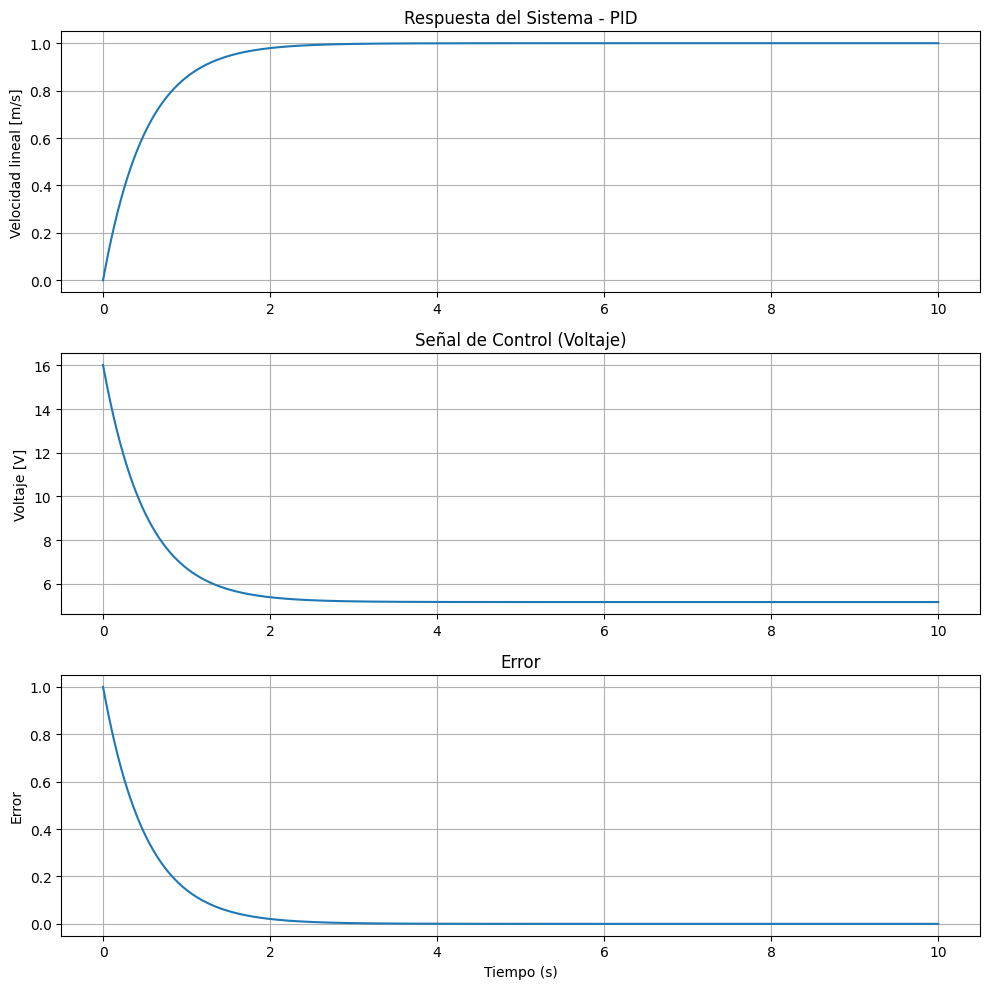

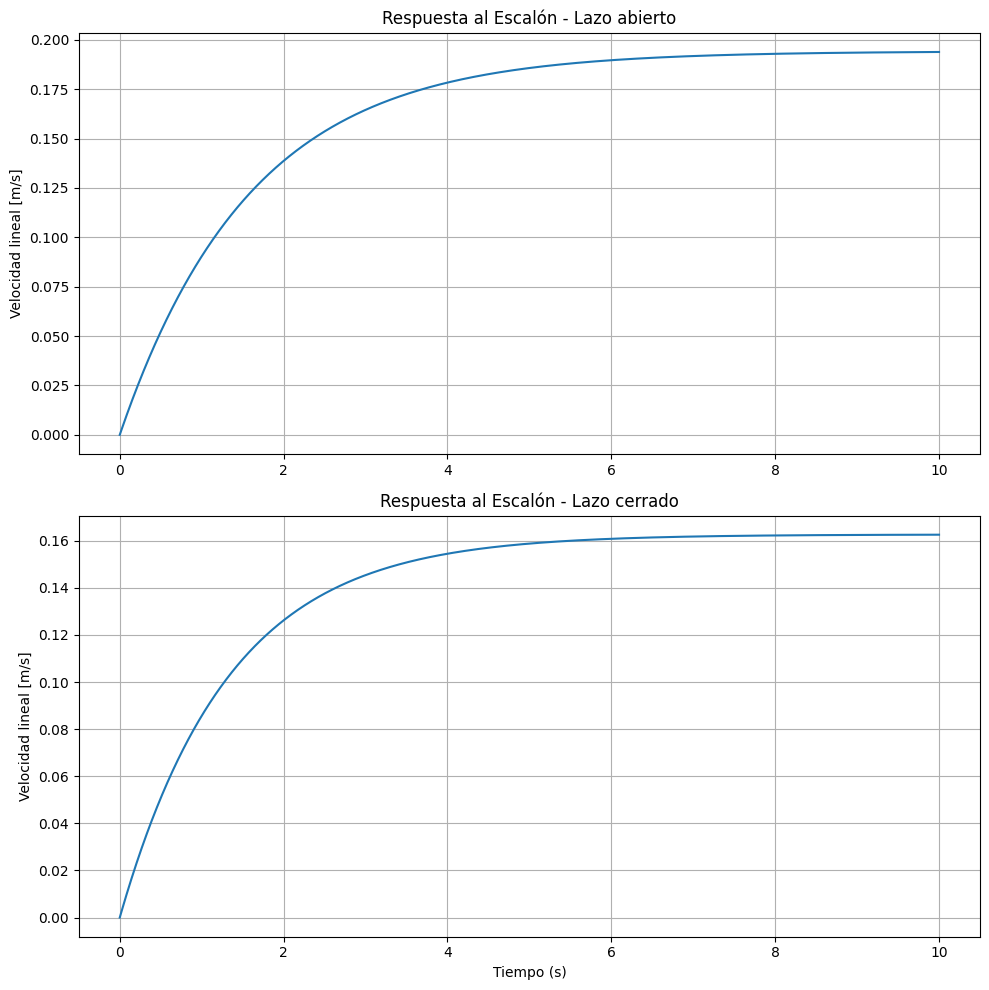

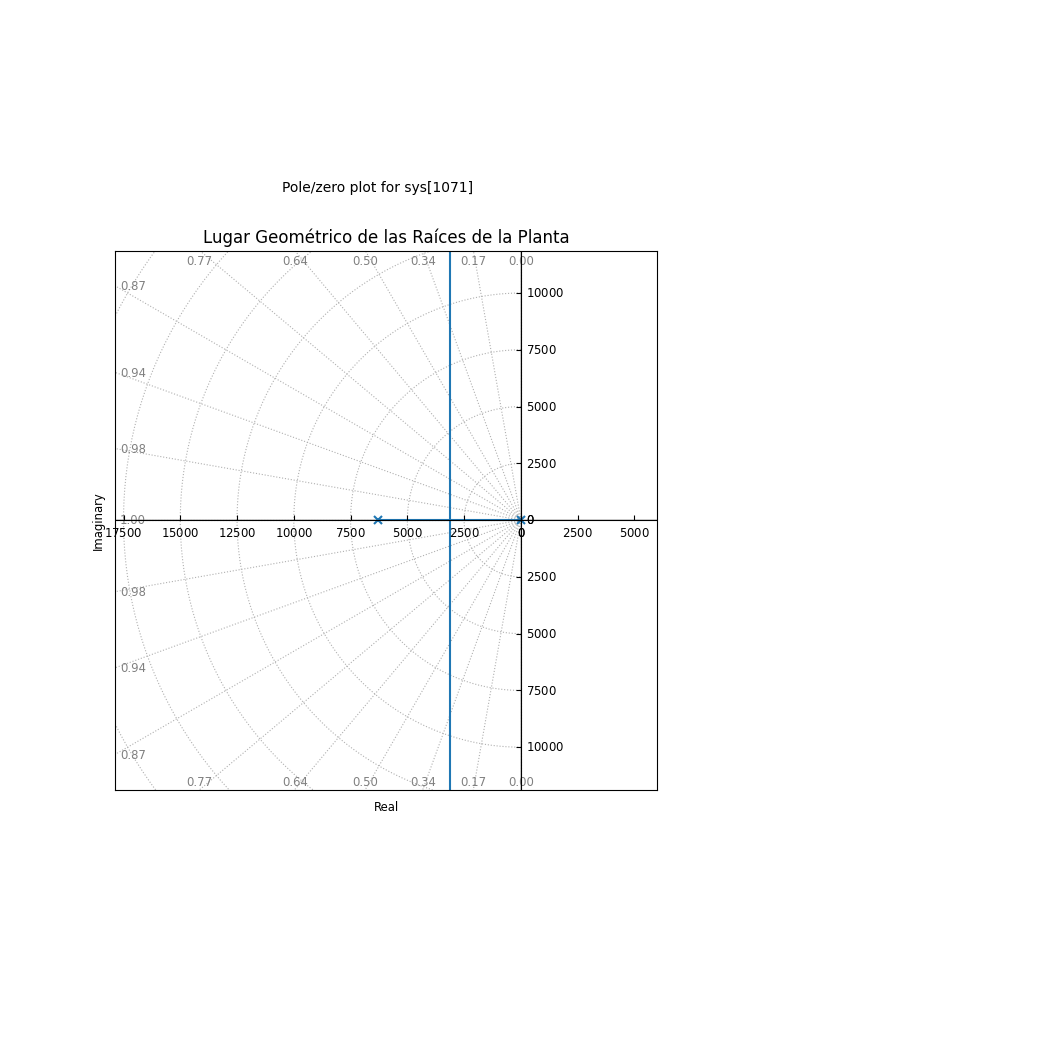

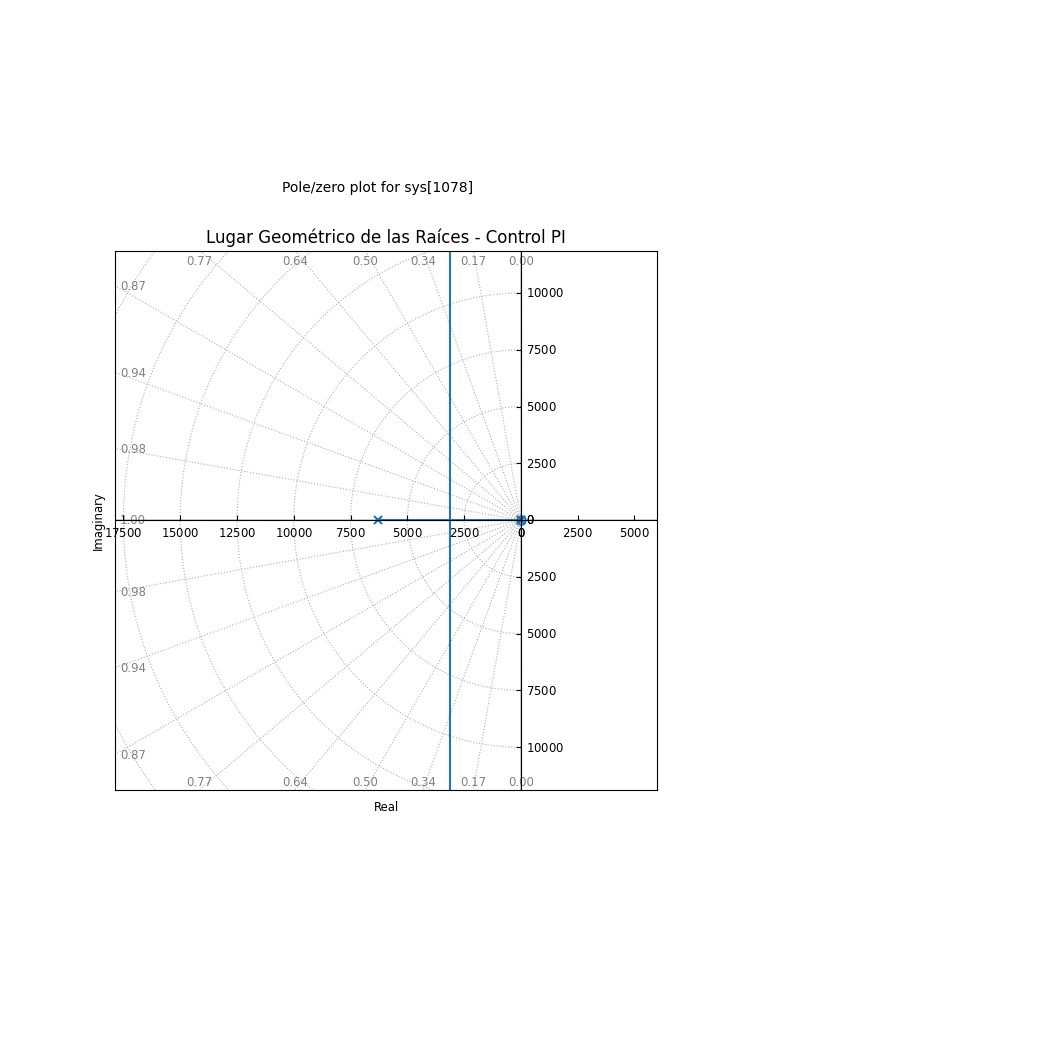

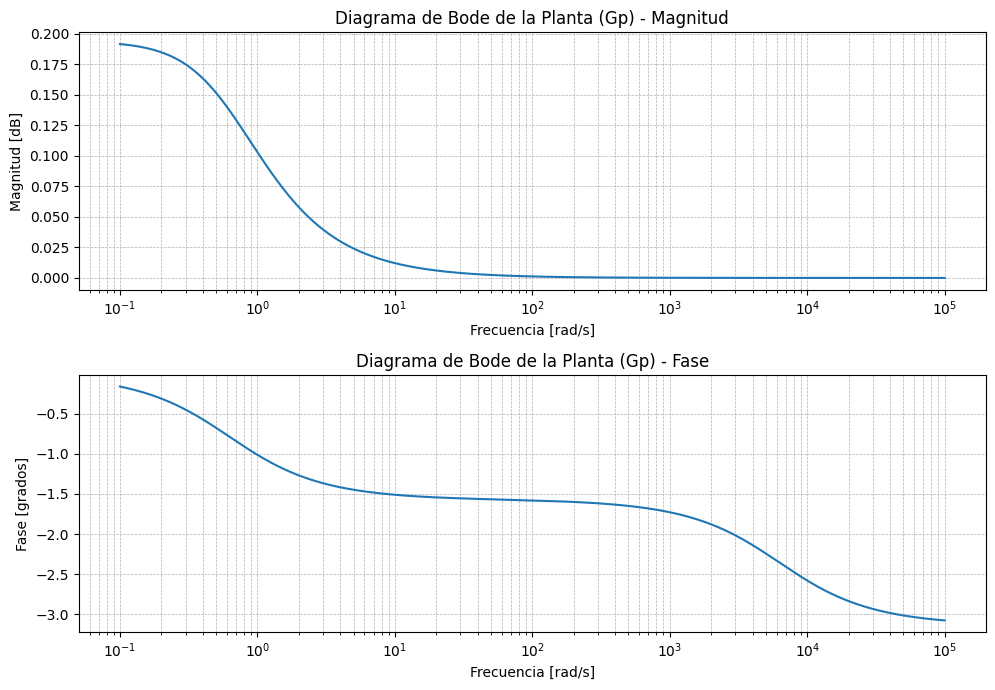

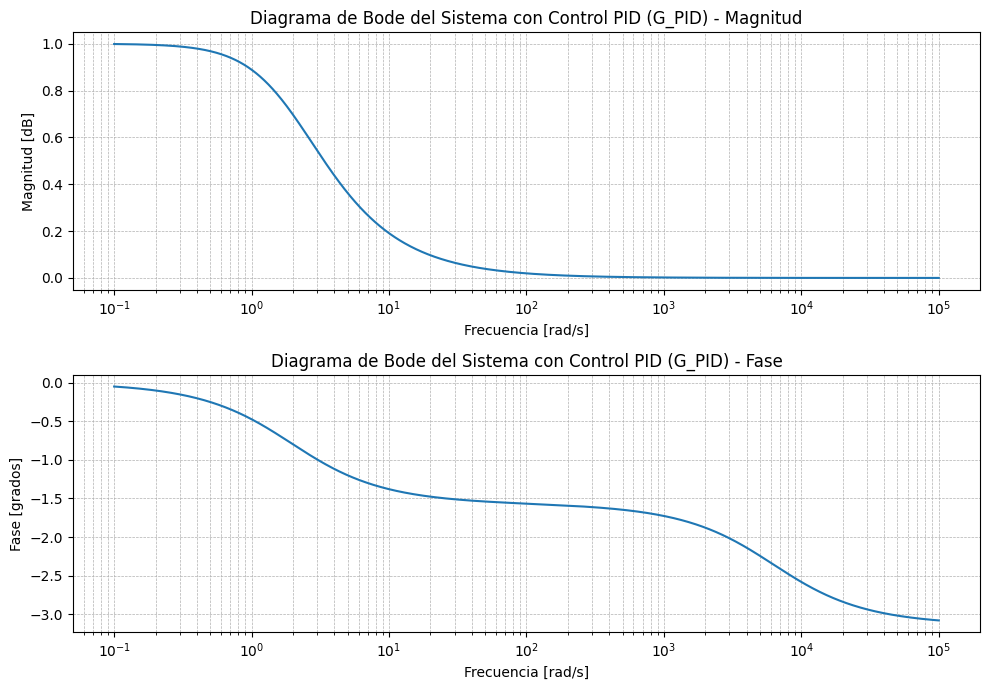

interactive(children=(FloatSlider(value=1.0, description='Kp', max=300.0), FloatSlider(value=0.0, description=…

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import control as ctrl
from control import bode_plot
import math
from scipy.optimize import minimize
from ipywidgets import interactive, FloatSlider, VBox, HBox, Checkbox
from IPython.display import display

# Parámetros del motor en SI
R = 0.628                # Ohm                 --> R   = resistencia en bornes
L = 0.10 * (10**(-3))    # mH a H              --> L   = inductancia en bornes
Jm = 6.02 * (10**(-6))   # g*cm^2 a kg*m^2     --> Jm  = inercia del rotor
B = 10**(-5)             # N*m*rad/s           --> B   = fricción mecánica
k1 = 25.5 * (10**(-3))   # mV*s/rad a V*s/rad  --> k1  = constante de FEM
k2 = 25.5 * (10**(-3))   # mN*m/A a N*m/A      --> k2  = constante de par
n = 1/10                 #                     --> n   = relacion de transmision

# Parámetros de la cinta, rodillos y carga
Radio_Rodillos = 0.05                           # m         --> Diametro de cada rodillo (x2)
Masa_Rodillos = 0.35                              # Kg        --> Masa de cada rodillo
Longitud_Cinta = 10 + Radio_Rodillos * math.pi     # m         --> Longitud cinta, ida y vuelta
Ancho_Cinta = 0.7                                # m         --> Ancho de la cinta
Densidad_Cinta = 2.3                             #Kg/m^3    --> Densidad especifica del material de la cinta
Area_Cinta = Longitud_Cinta*Ancho_Cinta           # m^2       --> Area de la cinta, ida y vuelta
Masa_Cinta = Area_Cinta*Densidad_Cinta            # Kg        --> Masa de la cinta
Carga = 50                                       # Kg        --> Carga en la cinta transportadora

# Calculos sin carga (cinta + rodillos + transmision)
MOI_rollers = (1/4) * Masa_Rodillos * (Radio_Rodillos**2) * 2   # Kg*m^2    --> Momento de inercia de los rodillos (x2)
MOI_object = (Masa_Cinta + Carga) * (Radio_Rodillos**2)         # Kg*m^2    --> Momento de inercia de la cinta
MOI_gearbox = 6.3 * (10**(-5))                                  # Kg*m^2    --> Momento de inercia de la caja de cambios, le cambie 4 por un 5 para que no tenga tanto peso

# Calculos con carga (cinta + rodillos + transmision + carga)
MOI_sumatoria = MOI_rollers + MOI_object + MOI_gearbox
Jcarga = (n**2) * MOI_sumatoria

# Calculos finales
Jeq = (Jm + Jcarga)
Beq = B

# Definicion de constantes
A = Jeq*L
B = (R*Jeq) + (Beq*L)
C = (R*Beq) + (k1*k2)
D = k2 * Radio_Rodillos * n

# Función de transferencia de la planta
s = ctrl.TransferFunction.s
Gp = D / ((A*s**2) + (B*s) + C)

# Obtener los polos de Gp
poles = ctrl.poles(Gp)
ceros = ctrl.zeros(Gp)
print("Polo 1 de Gp:", poles[0])
print("Polo 2 de Gp:", poles[1])
print(f"Ceros de la planta: {ceros}")

# Tiempos para simular
t = np.linspace(0, 10, 5000)

# Respuesta al escalón en LA
t, y_open_loop = ctrl.step_response(Gp, t)

# Sistema en lazo cerrado con H(s)=1
Gcl = ctrl.feedback(Gp)
poles = ctrl.poles(Gcl)
print("Polo 1 de Gcl:", poles[0])
print("Polo 2 de Gcl:", poles[1])

# Sistema en lazo cerrado con controlador PID
Kp = 16#20.4
Ki = 10#13.2
Kd = 0

C = ctrl.TransferFunction([Kd, Kp, Ki], [1, 0])
G_PID = ctrl.feedback(C * Gp, 1)
polos = ctrl.poles(G_PID)
ceros = ctrl.zeros(G_PID)
print(f"Polos del sistema PI: {polos}")
print(f"Ceros del sistema PI: {ceros}")

# Parametros caracteristicos 2do orden
omega = (poles[0]*poles[1])**(1/2)
sita  = abs(poles[0]+poles[1]) / (2*omega)
print("Omega:", omega)
print("sita:", sita)

# Respuesta al escalón en LC
t, y_closed_loop = ctrl.step_response(Gcl, t)

velocidad_objetivo = 1  # m/s
referencia = velocidad_objetivo * np.ones_like(t)

# Calcular la señal de control (voltaje)
t, y_PID= ctrl.forced_response(G_PID, T=t, U=referencia)
# Calcular el error
error = 1 - y_PID  # Asumiendo que la referencia es 1
# Calcular la señal de control (voltaje)
u = Kp * error + Ki * np.cumsum(error) * (t[1] - t[0]) + Kd * np.gradient(error, t)

# Crear la figura con subplots
plt.figure(figsize=(10, 10))

# Gráfica de la respuesta del sistema
plt.subplot(3, 1, 1)
plt.plot(t, y_PID)
plt.title('Respuesta del Sistema - PID')
plt.ylabel('Velocidad lineal [m/s]')
plt.grid(True)
plt.tight_layout()

# Gráfica de la señal de control (voltaje)
plt.subplot(3, 1, 2)
plt.plot(t, u)
plt.title('Señal de Control (Voltaje)')
plt.ylabel('Voltaje [V]')
plt.grid(True)
plt.tight_layout()

# Gráfica del error
plt.subplot(3, 1, 3)
plt.plot(t, error)
plt.title('Error')
plt.ylabel('Error')
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.tight_layout()

# Respuestas en función del tiempo
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)
plt.plot(t, y_open_loop)
plt.title('Respuesta al Escalón - Lazo abierto')
plt.ylabel('Velocidad lineal [m/s]')
plt.grid(True)
plt.tight_layout()

plt.subplot(2, 1, 2)
plt.plot(t, y_closed_loop)
plt.title('Respuesta al Escalón - Lazo cerrado')
plt.ylabel('Velocidad lineal [m/s]')
plt.xlabel('Tiempo (s)')
plt.grid(True)
plt.tight_layout()

# Gráfica del LGR
plt.figure(figsize=(7, 7))
ctrl.root_locus(Gp, plot=True, grid=True)
plt.title('Lugar Geométrico de las Raíces de la Planta')

plt.figure(figsize=(7, 7))
ctrl.root_locus(G_PID, plot=True, grid=True)
plt.title('Lugar Geométrico de las Raíces - Control PI')

# Diagrama de Bode para Gp
mag, phase, omega = ctrl.bode_plot(Gp, dB=True, Hz=False, deg=True, plot=False)

plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.semilogx(omega, mag)
plt.title('Diagrama de Bode de la Planta (Gp) - Magnitud')
plt.xlabel('Frecuencia [rad/s]')
plt.ylabel('Magnitud [dB]')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.subplot(2, 1, 2)
plt.semilogx(omega, phase)
plt.title('Diagrama de Bode de la Planta (Gp) - Fase')
plt.xlabel('Frecuencia [rad/s]')
plt.ylabel('Fase [grados]')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Diagrama de Bode para G_PID
mag, phase, omega = ctrl.bode_plot(G_PID, dB=True, Hz=False, deg=True, plot=False)

plt.figure(figsize=(10, 7))
plt.subplot(2, 1, 1)
plt.semilogx(omega, mag)
plt.title('Diagrama de Bode del Sistema con Control PID (G_PID) - Magnitud')
plt.xlabel('Frecuencia [rad/s]')
plt.ylabel('Magnitud [dB]')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)

plt.subplot(2, 1, 2)
plt.semilogx(omega, phase)
plt.title('Diagrama de Bode del Sistema con Control PID (G_PID) - Fase')
plt.xlabel('Frecuencia [rad/s]')
plt.ylabel('Fase [grados]')
plt.grid(True, which="both", linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

def update_plot(Kp, Ki, Kd):
    try:
        settling_band=0.05  # 2% por defecto
        C = ctrl.tf([Kd, Kp, Ki], [1, 0])
        G_PID = ctrl.feedback(C * Gp, 1)

        # Calcular polos del sistema en lazo cerrado
        polos = ctrl.poles(G_PID)

        t = np.linspace(0, 5, 5000)
        t, y = ctrl.step_response(G_PID, T=t)

        # Configurar la banda del tiempo de asentamiento
        info = ctrl.step_info(G_PID, SettlingTimeThreshold=settling_band)

        settling_time = info['SettlingTime']
        overshoot = info['Overshoot']

        plt.figure(figsize=(10, 4))
        plt.plot(t, y)
        plt.plot(t, np.ones_like(t), 'r--')
        plt.title(f'Respuesta PI (Kp={Kp:.2f}, Ki={Ki:.2f})')
        plt.xlabel('Tiempo')
        plt.ylabel('Velocidad Lineal')
        #plt.ylim(min(min(y), 0) - 0.1, max(max(y), 1) + 0.1)  # Ajustar los límites del eje y dinámicamente

        # Dibujar las líneas de la banda de asentamiento
        plt.axhline(y=1+settling_band, color='g', linestyle=':', label=f'Banda de asentamiento ({settling_band*100}%)')
        plt.axhline(y=1-settling_band, color='g', linestyle=':')

        plt.axvline(x=settling_time, color='g', linestyle='--', label=f'Tiempo de asentamiento: {settling_time:.2f}s')
        if overshoot > 0:
            overshoot_time = t[np.argmax(y)]
            plt.plot(overshoot_time, np.max(y), 'ro', label=f'Sobrepaso: {overshoot:.2f}%')

        plt.xlim(0, 5)  # Ajustar los límites del eje y dinámicamente
        plt.grid(True)
        plt.legend()
        plt.show()

        # Gráfico de la señal de control
        # error = 1 - y
        # u = Kp * error + Ki * np.cumsum(error) * (t[1] - t[0]) + Kd * np.gradient(error, t)
        # plt.figure(figsize=(10, 4))
        # plt.plot(t, u)
        # plt.plot(t, np.ones_like(t), 'r--')
        # plt.title('Señal de Control')
        # plt.xlabel('Tiempo')
        # plt.ylabel('Voltaje')
        # plt.tight_layout()

        # plt.grid(True)
        # plt.show()

        # plt.figure(figsize=(10, 4))
        # plt.plot(t, y)
        # plt.title(f'Respuesta PI (Kp={Kp:.2f}, Ki={Ki:.2f})')
        # plt.xlabel('Tiempo')
        # plt.ylabel('Velocidad Lineal')
        # plt.grid(True)
        # plt.show()

        print(f"Tiempo de asentamiento ({settling_band*100}%): {settling_time:.2f} s")
        print(f"Sobrepaso: {overshoot:.2f}%")
        print(f"Polos del sistema: {polos}")

    except Exception as e:
        print(f"Error en la simulación: {str(e)}")

# Crear sliders con rangos más amplios
Kp_slider = FloatSlider(value=1, min=0, max=300, step=0.1, description='Kp')
Ki_slider = FloatSlider(value=0, min=0, max=300, step=0.1, description='Ki')
Kd_slider = FloatSlider(value=0, min=0, max=10, step=0.01, description='Kd')

interactive_plot = interactive(update_plot, Kp=Kp_slider, Ki=Ki_slider, Kd=Kd_slider)
display(interactive_plot)


In [ ]:
Gp

TransferFunction(array([7.65e-05]), array([9.16895186e-08, 5.75811177e-04, 6.56530000e-04]))

In [ ]:
Gcl

TransferFunction(array([7.65e-05]), array([9.16895186e-08, 5.75811177e-04, 7.33030000e-04]))

In [ ]:
Gpid

TransferFunction(array([7.65e-05]), array([9.16895186e-08, 5.75811177e-04, 6.56530000e-04, 7.65000000e-05]))

Polos deseados:  (-1.7995949999999998+2.456314889417682j) (-1.7995949999999998-2.456314889417682j)


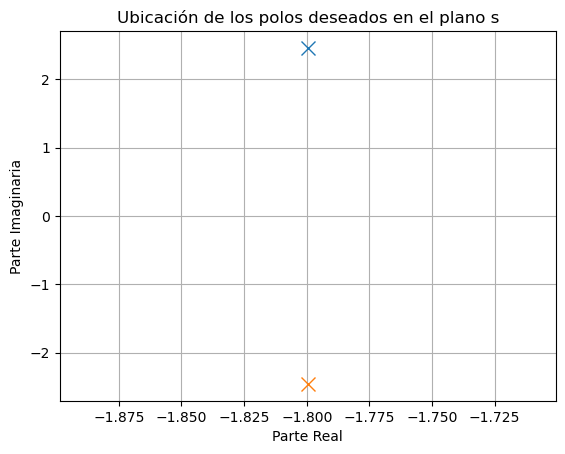

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Especificaciones técnicas. Las calculan a partir de los requrimientos
zeta = 0.591
wn = 3.045

# Polos deseados
s1 = -zeta*wn + wn*np.sqrt(1-zeta**2)*1j
s2 = -zeta*wn - wn*np.sqrt(1-zeta**2)*1j

# Imprimen los polos deseados
print('Polos deseados: ', s1, s2)

# Grafican los polos deseados
plt.figure()
plt.plot(np.real(s1), np.imag(s1), 'x', markersize=10)
plt.plot(np.real(s2), np.imag(s2), 'x', markersize=10)
plt.title('Ubicación de los polos deseados en el plano s')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import cmath

#Polos de la planta
p1, p2 = -1, -1

# Ángulos que los polos de la planta contribuyen en s1 (polo deseado)
angle_p1 = cmath.phase(s1 - p1) * 180 / np.pi
angle_p2 = cmath.phase(s1 - p2) * 180 / np.pi
# Ángulo total de la planta en s1
angle_plant = angle_p1 + angle_p2
# Cálculo de la deficiencia de ángulo
deficiency_angle = 180 - angle_plant
# Imprimen la deficiencia de ángulo
print('Deficiencia de ángulo: ', deficiency_angle, 'grados')


Deficiencia de ángulo:  -36.062858567772196 grados


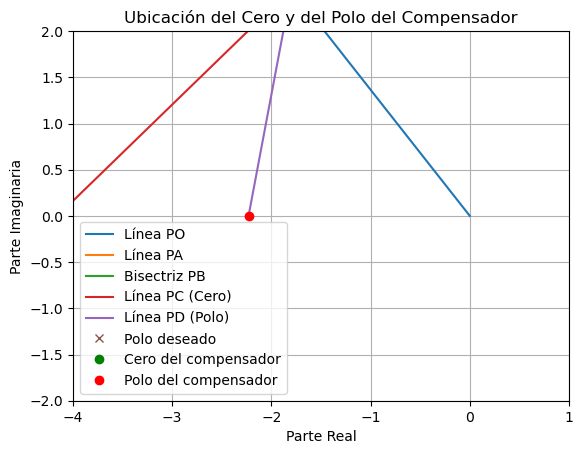

Ubicación del cero:  -4.15650757051151
Ubicación del polo:  -2.230724915739527


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Polo deseado (s1) en el plano complejo
s1_real=-zeta*wn
s1_imag=wn*np.sqrt(1-zeta**2)
s1_complex = s1_real + s1_imag*1j
s1 = -zeta*wn + wn*np.sqrt(1-zeta**2)*1j
# Línea PO: desde el origen hasta s1
PO_angle = np.angle(s1_complex)
# Línea PA: horizontal desde s1
PA_angle = np.pi
# Bisectriz PB: ángulo medio entre PO y PA
PB_angle = (PO_angle + PA_angle) / 2
# Líneas PC y PD: desviación de PB por theta/2
PC_angle = PB_angle - zeta/2
PD_angle = PB_angle + zeta/2
# Ubicación del cero y del polo del compensador (intersección con el eje real)
zero_loc = s1_real + np.tan(PC_angle) * s1_imag
pole_loc = s1_real + np.tan(PD_angle) * s1_imag

# Gráfico
plt.figure()
plt.plot([0, s1_real], [0, s1_imag], label='Línea PO')
plt.plot([s1_real, s1_real - 4], [s1_imag, s1_imag], label='Línea PA')
plt.plot([s1_real, s1_real - 4], [s1_imag, (s1_real - 4) * np.tan(PB_angle)], label='Bisectriz PB')
plt.plot([s1_real, zero_loc], [s1_imag, 0], label='Línea PC (Cero)')
plt.plot([s1_real, pole_loc], [s1_imag, 0], label='Línea PD (Polo)')
plt.plot(s1_real, s1_imag, 'x', label='Polo deseado')
plt.plot(zero_loc, 0, 'go', label='Cero del compensador')
plt.plot(pole_loc, 0, 'ro', label='Polo del compensador')
plt.xlim(-4, 1)
plt.ylim(-2, 2)
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')
plt.title('Ubicación del Cero y del Polo del Compensador')
plt.legend()
plt.grid(True)
plt.show()

print('Ubicación del cero: ', zero_loc)
print('Ubicación del polo: ', pole_loc)


In [ ]:
# Cálculo de T y alfa
T = -1/zero_loc
alfa = -1/(pole_loc*T)

print('T: ', T)
print('alfa: ', alfa)


T:  0.2405865941624972
alfa:  1.863299029469777


In [ ]:
import cmath

# Calculan el valor de la función de transferencia del compensador (sin Kc)
# y la planta en el polo deseado
Gc_s1 = (s1 + 1/T) / (s1 + 1/(alfa*T))
Gp_s1 = 1 / ((s1)**2 + 2*s1 + 1)

# Calculan el módulo de la función de transferencia total (sin Kc)
mod_Gc_Gp_s1 = abs(Gc_s1 * Gp_s1)

# Despejan Kc de la ecuación
Kc = 1 / mod_Gc_Gp_s1

print('Kc: ', Kc)


Kc:  4.888426697247543


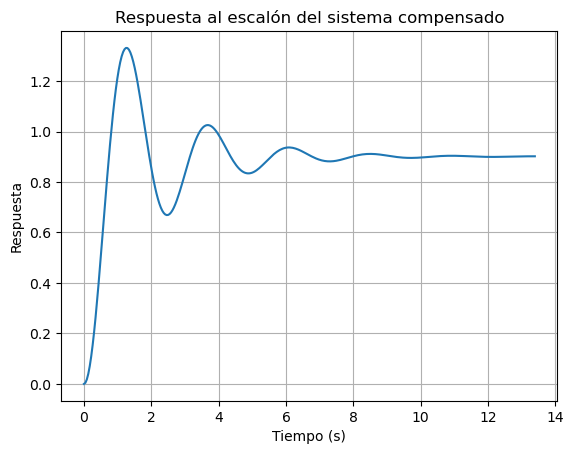

In [ ]:
import control as ctrl
import matplotlib.pyplot as plt

# Definen el compensador de adelanto utilizando los parámetros calculados
Kc=Kc*1
compensator = ctrl.TransferFunction([Kc, Kc/T], [1, 1/(alfa*T)])
# Define la planta
plant = ctrl.TransferFunction([1], [1, 2, 1])
# Construye el sistema compensado en lazo cerrado
system = ctrl.series(compensator, plant)
system_closed_loop = ctrl.feedback(system)
# Simula la respuesta al escalón
time, response = ctrl.step_response(system_closed_loop)
# Dibuja la respuesta
plt.figure()
plt.plot(time, response)
plt.title('Respuesta al escalón del sistema compensado')
plt.xlabel('Tiempo (s)')
plt.ylabel('Respuesta')
plt.grid()
plt.show()


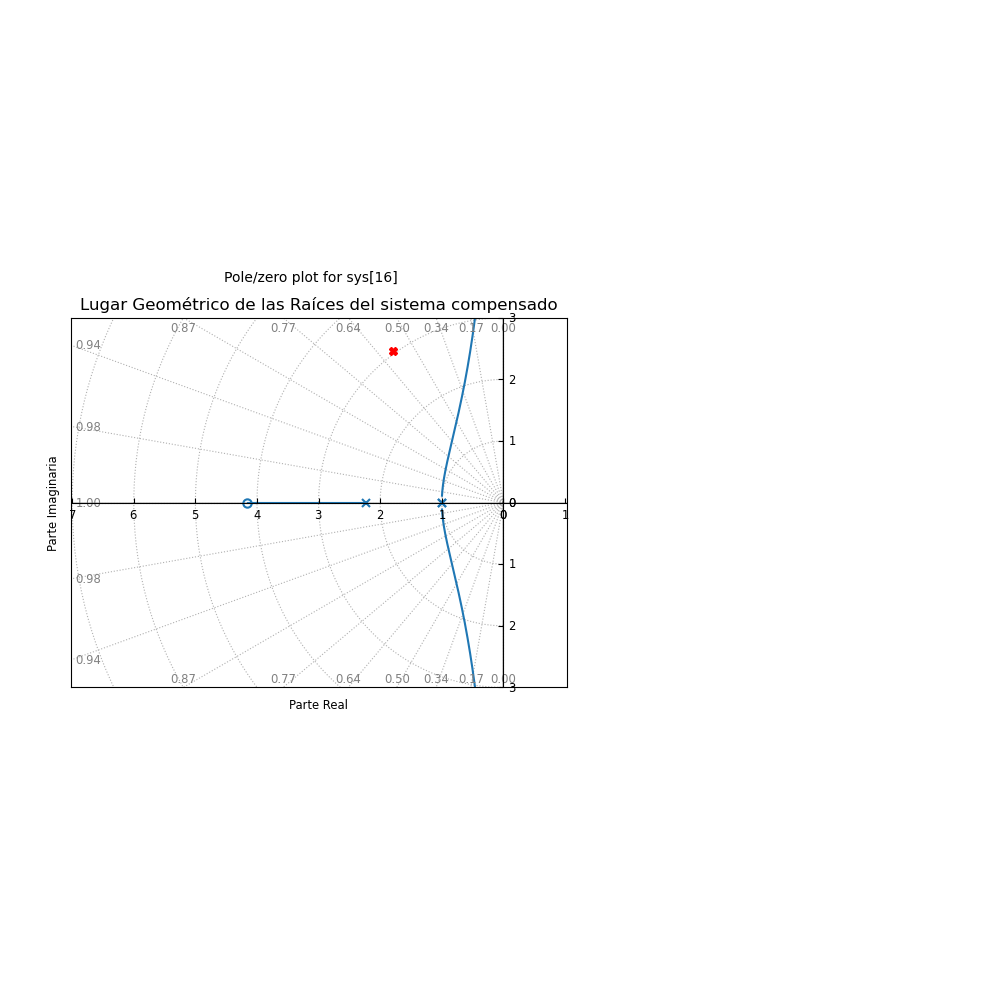

In [ ]:
# Genera una grilla de valores para la ganancia K
k_values = np.logspace(-3, 3, num=500)

# Calcula el LGR para el sistema compensado
ctrl.root_locus(system, kvect=k_values)

# Muestra el polo deseado
plt.plot(s1_real, s1_imag, 'rX')

plt.title('Lugar Geométrico de las Raíces del sistema compensado')
plt.xlabel('Parte Real')
plt.ylabel('Parte Imaginaria')

# Ajusta los límites de los ejes para hacer un zoom en la región de interés
plt.xlim([-6, 0])
plt.ylim([-3, 3])

plt.grid(True)
plt.show()


Podemos verificar que no fué suficiente con un compensador de adelanto a pesar de que logramos que los polos dominantes en lazo cerrado del sistema compensado coincidan con los deseados. No fué suficiente porque la respuesta temporal nos indica eso, lo podemos ver gráficamente.
Tanmbién podemos ver que el polo no dominante (Polo 3) se encuentra muy cerca de la parte real de los polos dominantes, eso nos está indicando que estaría afectando la respuesta de nuestro sistema e interfiriendo en la solución.
Lo que habría que hacer entonces es diseñar un compensador de atraso - adelanto para lograr cumplir con todos los requerimientos de manera simultánea.
La verficicación de la ubicación de los polos dominantes es un indicador de que hemos hecho e impelementado correctamente el método, solo que para esta situación partocular no fué suficiente.
Parte del proceso de diseño de sistemas de control implica la verificación de estas situación y la continuación del proceso de diseño.